In [1]:
import re
import time
from itertools import repeat
import jieba as jb
import matplotlib as mpl
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchnlp.encoders.text import StaticTokenizerEncoder
from torch.utils.tensorboard import SummaryWriter

In [2]:
df = pd.read_csv("dataset26p.csv", encoding="utf8")
df = df[['cat', 'keyword']]
df = df.assign(cat=df['cat'].str.upper())
print("数据总量: %d ." % len(df))
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 keyword 列中总共有 %d 个空值." % df['keyword'].isnull().sum())

数据总量: 133425 .
在 cat 列中总共有 0 个空值.
在 keyword 列中总共有 0 个空值.


In [3]:
import os
df = pd.read_csv("dataset_reduce.csv", encoding="utf-8")
df.head()

cat                                        cut_keyword
0   R  道家 文化 中医学 道家 文化 研究 中医学 医学史 研究 本书 充足 史料 逻辑 证明 道...
1   R  中医学 中国 医药学 研究 研究 中国 古代 本书 中国 源流 传世 作品 中医 渊源 讲 ...
2   R  甲骨 文化 中医学 中国 医药学 本书 共章 甲骨 文化 概述 甲骨文 中 医学 基础知识 ...
3   R  中国 中医 文化 传播 史 中国 医药学 文化 传播 医学史 中国 古代 本书 共 分为 十...
4   R  医学 革命 理论 思维 医学 伦理学 研究 本书 共 分为 医学 医学 哲学 医学 伦理学 ...

   cat  count
0    G  11094
1    K   9576
2    B   8255
3    F   8184
4    R   7803
5    D   7414
6    J   7028
7    S   6999
8    T   6876
9    Q   6719
10   C   6368
11   P   6054
12   A   5391
13   E   5230
14   X   5042
15   I   4641
16   N   4597
17   U   4587
18   O   4408
19   H   4089
20   V   2942


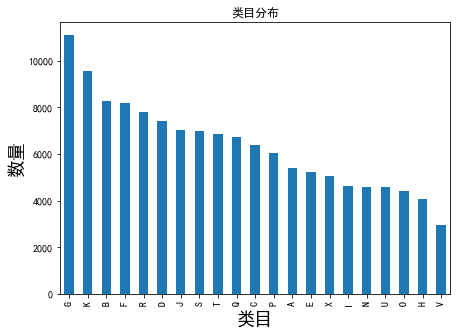

In [4]:
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 将data_count由Series先转换为dict再制作成DataFrame，以便绘制图表
data_count = df['cat'].value_counts()
data_count = {'cat': data_count.index, 'count': data_count}
df_cat = pd.DataFrame(data=data_count).reset_index(drop=True)
print(df_cat)

df_cat.plot(x='cat', y='count', kind='bar', legend=False, figsize=(7, 5))
plt.title(u"类目分布")
plt.ylabel(u'数量', fontsize=18)
plt.xlabel(u'类目', fontsize=18)
plt.show()

In [5]:
# 增加一列cat_id，为对应种类的id值
df['cat_id'] = df['cat'].factorize()[0]

# 降重、排序、重置索引
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)

# 种类与其id值互相映射的字典
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)

print(cat_id_df)

   cat  cat_id
0    R       0
1    S       1
2    F       2
3    C       3
4    A       4
5    D       5
6    H       6
7    T       7
8    O       8
9    K       9
10   I      10
11   B      11
12   E      12
13   G      13
14   J      14
15   N      15
16   P      16
17   Q      17
18   U      18
19   V      19
20   X      20


In [6]:
# # 定义删除除字母,数字，汉字以外的所有符号的函数
# def remove_punctuation(line):
#     line = str(line)
#     if line.strip() == '':
#         return ''
#     rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
#     line = rule.sub('', line)
#     return line


# def stopwords_list(filepath):
#     ret = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
#     return ret


# # 加载停用词
# stopwords = stopwords_list("chineseStopWords.txt")

# # 删除除字母,数字，汉字以外的所有符号
# df['clean_keyword'] = df['keyword'].apply(remove_punctuation)

# # 分词，并过滤停用词
# df['cut_keyword'] = df['clean_keyword'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
# print(df.head())

In [7]:
# df[["cat_id", "cut_keyword"]].to_csv("dataset26p_cutkeyword.csv",index=False,encoding="utf-8")

In [8]:
# df = pd.read_csv("dataset26p_cutkeyword.csv", encoding="utf8")
# df.head()

In [9]:
# 设置最频繁使用的80000个词
MAX_NB_WORDS = 152000

# 每条cut_keyword最大的长度50
MAX_SEQUENCE_LENGTH = 50

# 设置Embedding层的维度
EMBEDDING_DIM = 128

tok = StaticTokenizerEncoder(sample=df['cut_keyword'].values, tokenize=lambda x: x.split(),
                             reserved_tokens=['<pad>'])  # 初始化标注器

word_index = tok.token_to_index  # 查看对应的单词和数字的映射关系dict

# print(word_index)

X = [tok.encode(text) for text in df['cut_keyword'].values]  # 通过texts_to_sequences 这个dict可以将每个string的每个词转成数字

X.append(torch.tensor([0 for i in range(MAX_SEQUENCE_LENGTH)]))

# print(X)

# print(pd.DataFrame(X))
# 在前填充 使得矩阵前部分为0
tempX = []
for i in X:
    t = F.pad(i, (MAX_SEQUENCE_LENGTH - len(i), 0))
    tempX.append(t)

# 最后一行数据都是0 直接删除
tempX.pop()

# 生成张量
X = torch.cat(tempX, 0).view(-1, MAX_SEQUENCE_LENGTH)
# X = pad_sequence(X).T[:]

print(X, X.shape)

Y = df['cat_id'].values

print(type(Y), Y.shape)
print(type(X), X.shape)

X = np.array(X)
Y = np.array(Y)

print(type(Y), Y.shape)
print(type(X), X.shape)

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

print(type(Y), Y.shape)
print(type(X), X.shape)

tensor([[    0,     0,     0,  ...,    31,    32,    33],
        [    0,     0,     0,  ...,    59,    60,    61],
        [    2,     3,    34,  ...,    74,    86,    87],
        ...,
        [    0,     0,     0,  ...,  1357,  2021,   524],
        [    0,     0,     0,  ...,  2517,    32,    94],
        [18369,  2714,  1754,  ..., 11275,    66,   191]]) torch.Size([133297, 50])
<class 'numpy.ndarray'> (133297,)
<class 'torch.Tensor'> torch.Size([133297, 50])
<class 'numpy.ndarray'> (133297,)
<class 'numpy.ndarray'> (133297, 50)
<class 'torch.Tensor'> torch.Size([133297])
<class 'torch.Tensor'> torch.Size([133297, 50])


In [10]:
print(word_index)

{'<pad>': 0, '道家': 1, '文化': 2, '中医学': 3, '研究': 4, '医学史': 5, '本书': 6, '充足': 7, '史料': 8, '逻辑': 9, '证明': 10, '思想': 11, '中医理论': 12, '基石': 13, '回顾': 14, '发展史': 15, '概括': 16, '阴阳五行': 17, '藏象': 18, '经络': 19, '中医': 20, '基础理论': 21, '学说': 22, '理论': 23, '联系实际': 24, '洋为中用': 25, '原则': 26, '出发': 27, '介绍': 28, '共用': 29, '治疗': 30, '保健': 31, '技术': 32, '方法': 33, '中国': 34, '医药学': 35, '古代': 36, '源流': 37, '传世': 38, '作品': 39, '渊源': 40, '讲': 41, '阐述': 42, '特殊': 43, '现象': 44, '尝试': 45, '继承': 46, '传统': 47, '挖掘': 48, '艺术': 49, '价值': 50, '开拓': 51, '新': 52, '时代': 53, '对外': 54, '提升': 55, '国家': 56, '实力': 57, '增进': 58, '起到': 59, '一定': 60, '作用': 61, '甲骨': 62, '共章': 63, '概述': 64, '甲骨文': 65, '中': 66, '医学': 67, '基础知识': 68, '历史背景': 69, '诊疗': 70, '临床': 71, '各科': 72, '方面': 73, '进行': 74, '较为': 75, '全面': 76, '整理': 77, '考证': 78, '作者': 79, '考释': 80, '分析': 81, '建立': 82, '学术': 83, '框架': 84, '视角': 85, '综合': 86, '论述': 87, '传播': 88, '史': 89, '共': 90, '分为': 91, '十章': 92, '主要': 93, '内容': 94, '包括': 95, '原始社会': 96, '卫生': 97, '文明': 98, 

In [11]:
# 拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([119967, 50]) torch.Size([119967])
torch.Size([13330, 50]) torch.Size([13330])


In [12]:
class SpatialDropout(nn.Module):
    """
    空间dropout，即在指定轴方向上进行dropout，常用于Embedding层和CNN层后
    如对于(batch, timesteps, embedding)的输入，若沿着axis=1则可对embedding的若干channel进行整体dropout
    若沿着axis=2则可对某些token进行整体dropout
    """

    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.noise_shape = None
        self.drop = drop

    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple, 应当与inputs的shape一致，其中值为1的即沿着drop的轴
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim() - 2), inputs.shape[-1])  # 默认沿着中间所有的shape

        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)
            outputs.mul_(noises)
            return outputs

    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


class LSTMnet(nn.Module):
    def __init__(self, output_size, hidden_dim, embedding_dim, bidirectional):
        super(LSTMnet, self).__init__()
        self.output_size = output_size
        self.liner1_input_size = hidden_dim * 2 if bidirectional else hidden_dim
        self.Embedding = nn.Embedding(MAX_NB_WORDS, embedding_dim)
        #加入自定义层
        # self.spatialDropout=SpatialDropout(0.2)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, dropout=0.2, bidirectional=bidirectional,
                            num_layers=2)
        self.dropout1 = nn.Dropout(0.25)
        self.linear1 = nn.Linear(self.liner1_input_size, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(64, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # lstm输入应该是seq_len,batch，embedding_dim 所以在这先取转置
        x = x.t()
        x = self.Embedding(x)
        # x = self.spatialDropout(x)
        # print(x.shape)
        lstm_out, hidden = self.lstm(x)
        # print(lstm_out.shape)
        lstm_out = lstm_out[-1]  # 取最后一步输出
        # print(lstm_out.shape)
        out = self.dropout1(lstm_out)
        out = self.linear1(out)
        # print(out.shape)
        out = self.dropout2(out)
        out = self.linear2(out)
        # print(out.shape)
        out = self.sig(out)
        return out

In [13]:
# 模型参数
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 256

model = LSTMnet(output_size=21,
                hidden_dim=50,
                embedding_dim=EMBEDDING_DIM,
                bidirectional=True)

loss_function = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(),
                 lr=0.02,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False)

reduce_lr = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001)
# X_train=X_train.t()
# 通过dataloader实现分批次训练
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1200, shuffle=True)


In [23]:
now_time = time.time()

# 记录用于绘图
Train_loss = []
Train_accu = []
Test_loss = []
Test_accu = []


# 训练配置
is_continue = True
model_path = "lstm.pth"
last_epoch = 0
epochs = 50

# 开始训练
if not os.path.exists("record.txt") or not is_continue:
    with open("record.txt", "w") as file:
        file.write("0 2000 0\n")
else:
    with open("record.txt", "r") as file:
        enum = 0
        for line in file:
            if enum == 0:
                last_epoch, _, _ = line.split()
                enum = 1
            else:
                a,b,c,d = line.split()
                Train_loss.append(float(a))
                Train_accu.append(float(b))
                Test_loss.append(float(c))
                Test_accu.append(float(d))

last_epoch = int(last_epoch)

if is_continue:
    # 加载保存的部分参数，前提是model需要先定义
    model_dict = model.load_state_dict(torch.load(model_path))

print("start train")

# 到device上训练
model.to(device)
loss_function.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = []
    correct_test = []
    
    print('{} Epoch 【{}】 '.format('-' * 40, epoch+last_epoch))
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # print(outputs.shape,labels.shape)
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        # 如果创建了lr_scheduler对象之后，先调用scheduler.step()，再调用optimizer.step()，则会跳过了第一个学习率的值。
        # 调用顺序
        # loss.backward()
        # optimizer.step()
        # scheduler.step()
        optimizer.step()
        reduce_lr.step(loss)
        
        outputs = outputs.to('cpu')
        labels = labels.to('cpu')
        
        _, preds = outputs.max(1)
        correct = preds.eq(labels).sum().item() / len(labels)
        train_loss += loss.item()
        
        correct_train.append(correct)
        
        if i % 100 == 0 and i != 0:
            print('batch id {}\tloss {:.6f}\tacc {:.6f}'.format(i,loss.item(),correct))

        torch.cuda.empty_cache()
    
    correct = sum(correct_train)/len(correct_train)
    
    Train_loss.append(train_loss)
    Train_accu.append(100 * correct)
    print("Train_loss : {:.6f}".format(train_loss))
    print('Train_Accuracy : {:.6f}'.format(100 * correct))

    model.eval()
    with torch.no_grad():
        test_accu = 0
        test_loss = 0
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # print(outputs.shape,labels.shape)
            loss = loss_function(outputs, labels)
            
            outputs = outputs.to('cpu')
            labels = labels.to('cpu')
            
            _, preds = outputs.max(1)
            correct = preds.eq(labels).sum().item() / len(labels)
            test_loss += loss.item()
        
            correct_test.append(correct)
            
            torch.cuda.empty_cache()
            
        correct = sum(correct_test)/len(correct_test)
        
        Test_loss.append(test_loss)
        Test_accu.append(100 * correct)
        print("Test_loss : {:.6f}".format(test_loss))
        print('Test_Accuracy : {:.6f}'.format(100 * correct))
        
        # racord parts
        loss, acc = 1000, 0
        with open("record.txt", "r") as file:
            for line in file:
                _, loss, acc = line.split()
                break

        # 保存网络中的参数, 速度快，占空间少
        torch.save(model.state_dict(),model_path)
        
        with open("record.txt", "w") as file:
            file.write(" ".join([str(1+epoch+last_epoch), str(float(test_loss)), str(float(correct))]))
            for i in range(len(Test_accu)):
                file.write("\n")
                file.write(str(float(Train_loss[i])) + " ")
                file.write(str(float(Train_accu[i])) + " ")
                file.write(str(float(Test_loss[i])) + " ")
                file.write(str(float(Test_accu[i])))
                
total_time = time.time() - now_time
print("total time is: ", total_time)

start train
---------------------------------------- Epoch 【100】 
batch id 100	loss 2.159298	acc 0.890625
batch id 200	loss 2.155272	acc 0.917969
batch id 300	loss 2.175205	acc 0.906250
batch id 400	loss 2.168479	acc 0.882812
Train_loss : 1017.852781
Train_Accuracy : 89.522595
Test_loss : 27.173960
Test_Accuracy : 79.996795
---------------------------------------- Epoch 【101】 
batch id 100	loss 2.180068	acc 0.906250
batch id 200	loss 2.183938	acc 0.898438
batch id 300	loss 2.177535	acc 0.859375
batch id 400	loss 2.163812	acc 0.906250
Train_loss : 1017.571309
Train_Accuracy : 89.566922
Test_loss : 27.162190
Test_Accuracy : 79.793803
---------------------------------------- Epoch 【102】 
batch id 100	loss 2.164788	acc 0.894531
batch id 200	loss 2.174872	acc 0.910156
batch id 300	loss 2.170410	acc 0.910156
batch id 400	loss 2.174963	acc 0.898438
Train_loss : 1017.951047
Train_Accuracy : 89.497467
Test_loss : 27.180021
Test_Accuracy : 79.958868
---------------------------------------- Epoch

batch id 100	loss 2.163751	acc 0.902344
batch id 200	loss 2.162451	acc 0.898438
batch id 300	loss 2.158641	acc 0.914062
batch id 400	loss 2.149335	acc 0.902344
Train_loss : 1015.286843
Train_Accuracy : 90.135827
Test_loss : 27.117763
Test_Accuracy : 80.294872
---------------------------------------- Epoch 【127】 
batch id 100	loss 2.170843	acc 0.878906
batch id 200	loss 2.157137	acc 0.906250
batch id 300	loss 2.164276	acc 0.914062
batch id 400	loss 2.167873	acc 0.871094
Train_loss : 1015.154441
Train_Accuracy : 90.244935
Test_loss : 27.152598
Test_Accuracy : 80.084936
---------------------------------------- Epoch 【128】 
batch id 100	loss 2.161015	acc 0.906250
batch id 200	loss 2.181328	acc 0.867188
batch id 300	loss 2.167920	acc 0.890625
batch id 400	loss 2.162113	acc 0.917969
Train_loss : 1015.439056
Train_Accuracy : 90.170400
Test_loss : 27.107463
Test_Accuracy : 80.237179
---------------------------------------- Epoch 【129】 
batch id 100	loss 2.192529	acc 0.847656
batch id 200	loss 

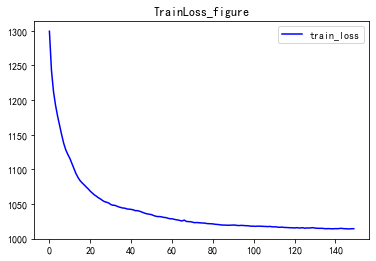

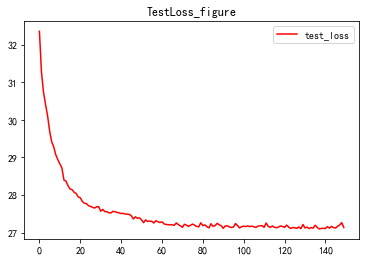

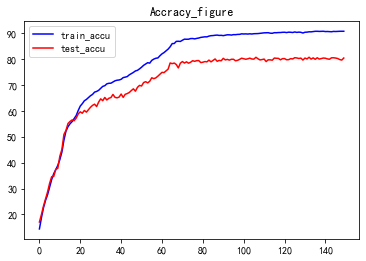

In [24]:
# 绘制训练结果图像
plt.title('TrainLoss_figure')
plt.plot(range(epochs+last_epoch), Train_loss, label='train_loss', color='b')
plt.legend()
plt.show()

plt.title('TestLoss_figure')
plt.plot(range(epochs+last_epoch), Test_loss, label='test_loss', color='r')
plt.legend()
plt.show()
# 绘制测试结果图像
plt.title('Accracy_figure')
plt.plot(range(epochs+last_epoch), Train_accu, label='train_accu', color='b')
plt.plot(range(epochs+last_epoch), Test_accu, label='test_accu', color='r')
plt.legend()
plt.show()

In [16]:
m = [1,2,3,4]
sum(m)/len(m)

2.5

In [25]:
id_to_cat

{0: 'R',
 1: 'S',
 2: 'F',
 3: 'C',
 4: 'A',
 5: 'D',
 6: 'H',
 7: 'T',
 8: 'O',
 9: 'K',
 10: 'I',
 11: 'B',
 12: 'E',
 13: 'G',
 14: 'J',
 15: 'N',
 16: 'P',
 17: 'Q',
 18: 'U',
 19: 'V',
 20: 'X'}

In [26]:
df = pd.read_csv("dataset_reduce.csv", encoding="utf-8")
df.head()

cat                                        cut_keyword
0   R  道家 文化 中医学 道家 文化 研究 中医学 医学史 研究 本书 充足 史料 逻辑 证明 道...
1   R  中医学 中国 医药学 研究 研究 中国 古代 本书 中国 源流 传世 作品 中医 渊源 讲 ...
2   R  甲骨 文化 中医学 中国 医药学 本书 共章 甲骨 文化 概述 甲骨文 中 医学 基础知识 ...
3   R  中国 中医 文化 传播 史 中国 医药学 文化 传播 医学史 中国 古代 本书 共 分为 十...
4   R  医学 革命 理论 思维 医学 伦理学 研究 本书 共 分为 医学 医学 哲学 医学 伦理学 ...

In [30]:
tok = StaticTokenizerEncoder(sample=df['cut_keyword'].values, tokenize=lambda x: x.split(),
                             reserved_tokens=['<pad>'])  # 初始化标注器
print(tok.token_to_index)

{'<pad>': 0, '道家': 1, '文化': 2, '中医学': 3, '研究': 4, '医学史': 5, '本书': 6, '充足': 7, '史料': 8, '逻辑': 9, '证明': 10, '思想': 11, '中医理论': 12, '基石': 13, '回顾': 14, '发展史': 15, '概括': 16, '阴阳五行': 17, '藏象': 18, '经络': 19, '中医': 20, '基础理论': 21, '学说': 22, '理论': 23, '联系实际': 24, '洋为中用': 25, '原则': 26, '出发': 27, '介绍': 28, '共用': 29, '治疗': 30, '保健': 31, '技术': 32, '方法': 33, '中国': 34, '医药学': 35, '古代': 36, '源流': 37, '传世': 38, '作品': 39, '渊源': 40, '讲': 41, '阐述': 42, '特殊': 43, '现象': 44, '尝试': 45, '继承': 46, '传统': 47, '挖掘': 48, '艺术': 49, '价值': 50, '开拓': 51, '新': 52, '时代': 53, '对外': 54, '提升': 55, '国家': 56, '实力': 57, '增进': 58, '起到': 59, '一定': 60, '作用': 61, '甲骨': 62, '共章': 63, '概述': 64, '甲骨文': 65, '中': 66, '医学': 67, '基础知识': 68, '历史背景': 69, '诊疗': 70, '临床': 71, '各科': 72, '方面': 73, '进行': 74, '较为': 75, '全面': 76, '整理': 77, '考证': 78, '作者': 79, '考释': 80, '分析': 81, '建立': 82, '学术': 83, '框架': 84, '视角': 85, '综合': 86, '论述': 87, '传播': 88, '史': 89, '共': 90, '分为': 91, '十章': 92, '主要': 93, '内容': 94, '包括': 95, '原始社会': 96, '卫生': 97, '文明': 98, 

In [63]:
cat_to_chinese = {
    'A': '马克思主义、列宁主义、毛泽东思想、邓小平理论',
    'B': '哲学、宗教',
    'C': '社会科学总论',
    'D': '政治、法律',
    'E': '军事',
    'F': '经济',
    'G': '文化、科学、教育、体育',
    'H': '语言、文字',
    'I': '文学',
    'J': '艺术',
    'K': '历史、地理',
    'N': '自然科学总论',
    'O': '数理科学和化学',
    'P': '天文学、地球科学',
    'Q': '生物科学',
    'R': '医药、卫生',
    'S': '农业科学',
    'T': '工业技术',
    'U': '交通运输',
    'V': '航空、航天',
    'X': '环境科学、安全科学',
    'Z': '综合性图书'
}

In [32]:
# 定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('', line)
    return line


def stopwords_list(filepath):
    ret = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return ret

stopwords = stopwords_list("chineseStopWords.txt")

In [261]:
def predicts(inputx):
    
    inputx = remove_punctuation(inputx)
    inputx = " ".join([w for w in list(jb.cut(inputx)) if w not in stopwords])
#     print(inputx)
    inputx = tok.encode(inputx)
    
    inputx = np.array([np.array(inputx)])
    
#     print(inputx, type(inputx), inputx.shape)

    inputx = torch.from_numpy(inputx)

#     print(inputx)
    
    model = LSTMnet(output_size=21,
                    hidden_dim=50,
                    embedding_dim=EMBEDDING_DIM,
                    bidirectional=True)
    
    model.load_state_dict(torch.load(model_path))
    
    pred = model(inputx)
    pred = pred.detach().numpy()[0]
    
    great_arg = [i for i in pred.argsort()[-3:][::-1]]
#     print(great_arg)
    
    out = ['\t{}.{} :\n\t\t {:.15f}\n'.format(ix+1, cat_to_chinese[id_to_cat[int(i)]], pred[int(i)]) for ix, i in enumerate(great_arg)]
    
    put = 'Out:判断该文段的标签应为:【{}】{}'.format(id_to_cat[int(great_arg[0])], cat_to_chinese[id_to_cat[int(great_arg[0])]])
    
    
    if pred[int(great_arg[0])] -  pred[int(great_arg[1])] <= 0.0005:
        put += '\nOut:判断该文段存在副标签:【{}】{}'.format(id_to_cat[int(great_arg[1])], cat_to_chinese[id_to_cat[int(great_arg[1])]])
#     print(out)
    
    return '输入文段的类别概率为\n' + ' '.join(out) + put
    
    # 加载停用词
    # 

    # 删除除字母,数字，汉字以外的所有符号
    # df['clean_keyword'] = df['keyword'].apply(remove_punctuation)

    # 分词，并过滤停用词
    # df['cut_keyword'] = df['clean_keyword'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
    # print(df.head())

In [262]:
words = "文化输出是指一个国家为了达到某种目的,主动而有意识地将其传统的价值观传播或强加给其他国家的过程。"
print(predicts(words))

输入文段的类别概率为
	1.政治、法律 :
		 1.000000000000000
 	2.哲学、宗教 :
		 1.000000000000000
 	3.艺术 :
		 0.000000101166819
Out:判断该文段的标签应为:【D】政治、法律
Out:判断该文段存在副标签:【B】哲学、宗教


In [407]:
words1 = "《黄帝内经•异法方宜》这是一本教我们最快找到自己人生风水宝地的养生风水学经典，" + \
"也是当今讲得最好的黄帝内经，其精彩内容之前一直藏在深闺人未识，如今，由医道相通的中医大" + \
"家徐文兵和凤凰卫视名嘴梁冬以出神入化、逐字逐句解读并结合当下人生活的方式来重新发现，告" + \
"诉你不管是生活在出生地还是背井离乡，都能根据当地“地利”的优势和能量来养心养身，汲取向" + \
"上的生机，把生活变得蒸蒸日上。" + \
"人活一世，要想过得风调雨顺，身心无虞，是离不开“天时地利人和”的。天时大多要靠天赐，地利" + \
"人和却是我们自己可以掌握的。什么是地利？简单地说就是风水，如何找到自己的好风水，这是我们一生中孜孜以求的。"

words2 = "养生风水内经医道中医大家地利养心养身生机好风水"

print(predicts(words1))
print()
print(predicts(words2))

输入文段的类别概率为
	1.哲学、宗教 :
		 1.000000000000000
 	2.政治、法律 :
		 1.000000000000000
 	3.医药、卫生 :
		 0.000000085134637
Out:判断该文段的标签应为:【B】哲学、宗教
Out:判断该文段存在副标签:【D】政治、法律

输入文段的类别概率为
	1.医药、卫生 :
		 1.000000000000000
 	2.社会科学总论 :
		 0.000000000302421
 	3.语言、文字 :
		 0.000000000000071
Out:判断该文段的标签应为:【R】医药、卫生


In [346]:
from textrank4zh import TextRank4Keyword, TextRank4Sentence
def getKeywords_textrank4zh(data,topK,word,cat):
    wordList,catList = data[word],data[cat]
    cat, keys = [], []
    for index in range(len(catList)):
    # for index in range(100):
        text = '%s' % wordList[index]
        # print("\"", wordList[index], "\"", ' {} Keywords - TextRank :'.format(topK))
        tr4w = TextRank4Keyword()
        tr4w.analyze(text, lower=True)
        keylist = []
        key_words = tr4w.get_keywords(num=topK, word_min_len=1)
        # print('关键词为：')
        for item in key_words:
            # print(item.word, item.weight)
            keylist.append(item.word)
            word_split = " ".join(keylist)
        keys.append(word_split)
        cat.append(catList[index])
    result = pd.DataFrame({'cat':cat,'keyword': keys}, columns=['cat','keyword'])
    return result

ModuleNotFoundError: No module named 'textrank4zh'